In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### download data

In [2]:
! wget -q http://files.grouplens.org/datasets/movielens/ml-1m.zip
! unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


### define description and load data

In [3]:
age_desc = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
occupation_desc = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }

In [4]:
rating_data = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    engine="python",
    encoding="latin-1",
    names=['userid', 'movieid', 'rating', 'timestamp'])

user_data = pd.read_csv(
    "ml-1m/users.dat", 
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['userid', 'gender', 'age', 'occupation', 'zipcode']
)
user_data['age_desc'] = user_data['age'].apply(lambda x: age_desc[x])
user_data['occ_desc'] = user_data['occupation'].apply(lambda x: occupation_desc[x])

movie_data = pd.read_csv(
    "ml-1m/movies.dat",
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['movieid', 'title', 'genre']
)

dataset = pd.merge(pd.merge(rating_data, movie_data, how="left", on="movieid"), user_data, how="left", on="userid")

### train validation split

In [5]:
dataset = dataset.sample(frac=1, replace=False)

In [6]:
n_split = int(len(dataset)*.7)
trainset = dataset[:n_split]
validset = dataset[n_split:]

### build the model

In [7]:
def create_embeddings(num_users, num_movies, dim):
    user_embeddings = tf.get_variable(
        "theta",
        shape = [num_users, dim],
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    movie_embeddings = tf.get_variable(
        "phi",
        shape = [num_movies, dim],
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    return user_embeddings, movie_embeddings

def create_dataset(user_ids, movie_ids, ratings):
    user_id_var = tf.get_variable("userid", initializer=user_ids, trainable=False)
    movie_id_var = tf.get_variable("movieid", initializer=movie_ids, trainable=False)
    ratings_var = tf.get_variable("ratings", initializer=np.asarray(ratings, dtype=np.float32), trainable=False)
    return user_id_var, movie_id_var, ratings_var

def lookup_embeddings(user_embeddings, movie_embeddings, user_ids, movie_ids): 
    selected_user_embeddings = tf.gather(user_embeddings, user_ids)
    selected_movie_embeddings = tf.gather(movie_embeddings, movie_ids)
    return selected_user_embeddings, selected_movie_embeddings

def predict(selected_user_embeddings, selected_movie_embeddings):
    selected_predictions = tf.reduce_sum(
        selected_user_embeddings * selected_movie_embeddings,
        axis = 1
    )
    return selected_predictions

def colaborative_filtering(user_embeddings, movie_embeddings, user_ids, movie_ids):
    sel_usr_embs, sel_mov_embs = lookup_embeddings(user_embeddings, movie_embeddings, user_ids, movie_ids)
    predictions = predict(sel_usr_embs, sel_mov_embs)
    return predictions

def mean_squared_difference(predictions, ratings):
    difference = tf.reduce_mean(tf.squared_difference(predictions, ratings))
    return difference

### set hyper parameters

In [8]:
emb_dim = 8
learning_rate = 50
epochs = 1000

### train model

In [9]:
with tf.Graph().as_default():
    with tf.variable_scope("embeddings"):
        usr_embs, mov_embs = create_embeddings(dataset.userid.max()+1, dataset.movieid.max()+1, emb_dim)
    with tf.variable_scope("train_set"):
        train_data = trainset[["userid", "movieid", "rating"]].values.T
        train_usr_ids, train_mov_ids, train_ratings = create_dataset(*train_data)
    with tf.variable_scope("valid_set"):
        valid_data = validset[["userid", "movieid", "rating"]].values.T
        valid_usr_ids, valid_mov_ids, valid_ratings = create_dataset(*valid_data)
    with tf.variable_scope("training"):
        train_preds = colaborative_filtering(usr_embs, mov_embs, train_usr_ids, train_mov_ids)
        train_loss = mean_squared_difference(train_preds, train_ratings)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        train_usr_embs = optimizer.minimize(train_loss, var_list=[usr_embs])
        train_mov_embs = optimizer.minimize(train_loss, var_list=[mov_embs])   
    with tf.variable_scope("validation"):
        valid_preds = colaborative_filtering(usr_embs, mov_embs, valid_usr_ids, valid_mov_ids)
        valid_loss = mean_squared_difference(valid_preds, valid_ratings)
    with tf.Session() as sess:
        writer = tf.summary.FileWriter('Graph',sess.graph)
        sess.run(tf.global_variables_initializer())
        train_loss_history = []
        valid_loss_history = []
        for i in range(epochs):
            current_train_loss, _ = sess.run([train_loss, train_usr_embs])
            print("train loss after %ith user emb. opt. step: %f"%(i+1, current_train_loss))
            current_train_loss, _ = sess.run([train_loss, train_mov_embs])
            print("train loss after %ith movie emb. opt. step: %f"%(i+1, current_train_loss))
            current_valid_loss = sess.run(valid_loss)
            print("valid loss after %ith movie emb. opt. step: %f"%(i+1, current_valid_loss))
            train_loss_history.append(current_train_loss)
            valid_loss_history.append(current_valid_loss)
        final_user_embeddings, final_movie_embeddings = sess.run([usr_embs, mov_embs])
        final_valid_predictions = sess.run(valid_preds) 
        writer.close()

train loss after 1th user emb. opt. step: 14.069010
train loss after 1th movie emb. opt. step: 14.068967
valid loss after 1th movie emb. opt. step: 14.091018
train loss after 2th user emb. opt. step: 14.068924
train loss after 2th movie emb. opt. step: 14.068871
valid loss after 2th movie emb. opt. step: 14.091020
train loss after 3th user emb. opt. step: 14.068824
train loss after 3th movie emb. opt. step: 14.068773
valid loss after 3th movie emb. opt. step: 14.091022
train loss after 4th user emb. opt. step: 14.068728
train loss after 4th movie emb. opt. step: 14.068673
valid loss after 4th movie emb. opt. step: 14.091016
train loss after 5th user emb. opt. step: 14.068616
train loss after 5th movie emb. opt. step: 14.068560
valid loss after 5th movie emb. opt. step: 14.091006
train loss after 6th user emb. opt. step: 14.068504
train loss after 6th movie emb. opt. step: 14.068447
valid loss after 6th movie emb. opt. step: 14.090961
train loss after 7th user emb. opt. step: 14.068381


train loss after 53th user emb. opt. step: 2.417495
train loss after 53th movie emb. opt. step: 2.363928
valid loss after 53th movie emb. opt. step: 2.365859
train loss after 54th user emb. opt. step: 2.313399
train loss after 54th movie emb. opt. step: 2.264898
valid loss after 54th movie emb. opt. step: 2.270725
train loss after 55th user emb. opt. step: 2.219054
train loss after 55th movie emb. opt. step: 2.175027
valid loss after 55th movie emb. opt. step: 2.184195
train loss after 56th user emb. opt. step: 2.133283
train loss after 56th movie emb. opt. step: 2.093195
valid loss after 56th movie emb. opt. step: 2.105238
train loss after 57th user emb. opt. step: 2.055097
train loss after 57th movie emb. opt. step: 2.018512
valid loss after 57th movie emb. opt. step: 2.032997
train loss after 58th user emb. opt. step: 1.983597
train loss after 58th movie emb. opt. step: 1.950115
valid loss after 58th movie emb. opt. step: 1.966727
train loss after 59th user emb. opt. step: 1.918064


train loss after 105th movie emb. opt. step: 1.011337
valid loss after 105th movie emb. opt. step: 1.039451
train loss after 106th user emb. opt. step: 1.008439
train loss after 106th movie emb. opt. step: 1.006312
valid loss after 106th movie emb. opt. step: 1.034370
train loss after 107th user emb. opt. step: 1.003505
train loss after 107th movie emb. opt. step: 1.001464
valid loss after 107th movie emb. opt. step: 1.029476
train loss after 108th user emb. opt. step: 0.998749
train loss after 108th movie emb. opt. step: 0.996793
valid loss after 108th movie emb. opt. step: 1.024757
train loss after 109th user emb. opt. step: 0.994164
train loss after 109th movie emb. opt. step: 0.992286
valid loss after 109th movie emb. opt. step: 1.020199
train loss after 110th user emb. opt. step: 0.989736
train loss after 110th movie emb. opt. step: 0.987932
valid loss after 110th movie emb. opt. step: 1.015798
train loss after 111th user emb. opt. step: 0.985462
train loss after 111th movie emb. 

train loss after 156th movie emb. opt. step: 0.881856
valid loss after 156th movie emb. opt. step: 0.908726
train loss after 157th user emb. opt. step: 0.881050
train loss after 157th movie emb. opt. step: 0.880672
valid loss after 157th movie emb. opt. step: 0.907545
train loss after 158th user emb. opt. step: 0.879883
train loss after 158th movie emb. opt. step: 0.879513
valid loss after 158th movie emb. opt. step: 0.906385
train loss after 159th user emb. opt. step: 0.878736
train loss after 159th movie emb. opt. step: 0.878379
valid loss after 159th movie emb. opt. step: 0.905253
train loss after 160th user emb. opt. step: 0.877612
train loss after 160th movie emb. opt. step: 0.877267
valid loss after 160th movie emb. opt. step: 0.904148
train loss after 161th user emb. opt. step: 0.876518
train loss after 161th movie emb. opt. step: 0.876180
valid loss after 161th movie emb. opt. step: 0.903063
train loss after 162th user emb. opt. step: 0.875446
train loss after 162th movie emb. 

train loss after 208th movie emb. opt. step: 0.841760
valid loss after 208th movie emb. opt. step: 0.869526
train loss after 209th user emb. opt. step: 0.841392
train loss after 209th movie emb. opt. step: 0.841248
valid loss after 209th movie emb. opt. step: 0.869044
train loss after 210th user emb. opt. step: 0.840884
train loss after 210th movie emb. opt. step: 0.840740
valid loss after 210th movie emb. opt. step: 0.868568
train loss after 211th user emb. opt. step: 0.840378
train loss after 211th movie emb. opt. step: 0.840240
valid loss after 211th movie emb. opt. step: 0.868099
train loss after 212th user emb. opt. step: 0.839878
train loss after 212th movie emb. opt. step: 0.839741
valid loss after 212th movie emb. opt. step: 0.867636
train loss after 213th user emb. opt. step: 0.839382
train loss after 213th movie emb. opt. step: 0.839243
valid loss after 213th movie emb. opt. step: 0.867178
train loss after 214th user emb. opt. step: 0.838894
train loss after 214th movie emb. 

train loss after 259th movie emb. opt. step: 0.819682
valid loss after 259th movie emb. opt. step: 0.849878
train loss after 260th user emb. opt. step: 0.819422
train loss after 260th movie emb. opt. step: 0.819290
valid loss after 260th movie emb. opt. step: 0.849550
train loss after 261th user emb. opt. step: 0.819033
train loss after 261th movie emb. opt. step: 0.818902
valid loss after 261th movie emb. opt. step: 0.849227
train loss after 262th user emb. opt. step: 0.818646
train loss after 262th movie emb. opt. step: 0.818516
valid loss after 262th movie emb. opt. step: 0.848903
train loss after 263th user emb. opt. step: 0.818259
train loss after 263th movie emb. opt. step: 0.818129
valid loss after 263th movie emb. opt. step: 0.848581
train loss after 264th user emb. opt. step: 0.817871
train loss after 264th movie emb. opt. step: 0.817738
valid loss after 264th movie emb. opt. step: 0.848260
train loss after 265th user emb. opt. step: 0.817481
train loss after 265th movie emb. 

train loss after 310th movie emb. opt. step: 0.799877
valid loss after 310th movie emb. opt. step: 0.834197
train loss after 311th user emb. opt. step: 0.799642
train loss after 311th movie emb. opt. step: 0.799484
valid loss after 311th movie emb. opt. step: 0.833900
train loss after 312th user emb. opt. step: 0.799251
train loss after 312th movie emb. opt. step: 0.799089
valid loss after 312th movie emb. opt. step: 0.833605
train loss after 313th user emb. opt. step: 0.798859
train loss after 313th movie emb. opt. step: 0.798697
valid loss after 313th movie emb. opt. step: 0.833313
train loss after 314th user emb. opt. step: 0.798464
train loss after 314th movie emb. opt. step: 0.798303
valid loss after 314th movie emb. opt. step: 0.833019
train loss after 315th user emb. opt. step: 0.798069
train loss after 315th movie emb. opt. step: 0.797905
valid loss after 315th movie emb. opt. step: 0.832726
train loss after 316th user emb. opt. step: 0.797670
train loss after 316th movie emb. 

train loss after 361th movie emb. opt. step: 0.779583
valid loss after 361th movie emb. opt. step: 0.819661
train loss after 362th user emb. opt. step: 0.779361
train loss after 362th movie emb. opt. step: 0.779183
valid loss after 362th movie emb. opt. step: 0.819391
train loss after 363th user emb. opt. step: 0.778961
train loss after 363th movie emb. opt. step: 0.778783
valid loss after 363th movie emb. opt. step: 0.819117
train loss after 364th user emb. opt. step: 0.778562
train loss after 364th movie emb. opt. step: 0.778387
valid loss after 364th movie emb. opt. step: 0.818846
train loss after 365th user emb. opt. step: 0.778166
train loss after 365th movie emb. opt. step: 0.777990
valid loss after 365th movie emb. opt. step: 0.818574
train loss after 366th user emb. opt. step: 0.777770
train loss after 366th movie emb. opt. step: 0.777591
valid loss after 366th movie emb. opt. step: 0.818306
train loss after 367th user emb. opt. step: 0.777370
train loss after 367th movie emb. 

train loss after 413th movie emb. opt. step: 0.759224
valid loss after 413th movie emb. opt. step: 0.806422
train loss after 414th user emb. opt. step: 0.759022
train loss after 414th movie emb. opt. step: 0.758844
valid loss after 414th movie emb. opt. step: 0.806189
train loss after 415th user emb. opt. step: 0.758644
train loss after 415th movie emb. opt. step: 0.758469
valid loss after 415th movie emb. opt. step: 0.805955
train loss after 416th user emb. opt. step: 0.758267
train loss after 416th movie emb. opt. step: 0.758090
valid loss after 416th movie emb. opt. step: 0.805724
train loss after 417th user emb. opt. step: 0.757889
train loss after 417th movie emb. opt. step: 0.757710
valid loss after 417th movie emb. opt. step: 0.805495
train loss after 418th user emb. opt. step: 0.757515
train loss after 418th movie emb. opt. step: 0.757337
valid loss after 418th movie emb. opt. step: 0.805262
train loss after 419th user emb. opt. step: 0.757137
train loss after 419th movie emb. 

train loss after 464th movie emb. opt. step: 0.740732
valid loss after 464th movie emb. opt. step: 0.795692
train loss after 465th user emb. opt. step: 0.740553
train loss after 465th movie emb. opt. step: 0.740390
valid loss after 465th movie emb. opt. step: 0.795503
train loss after 466th user emb. opt. step: 0.740212
train loss after 466th movie emb. opt. step: 0.740045
valid loss after 466th movie emb. opt. step: 0.795320
train loss after 467th user emb. opt. step: 0.739868
train loss after 467th movie emb. opt. step: 0.739702
valid loss after 467th movie emb. opt. step: 0.795133
train loss after 468th user emb. opt. step: 0.739527
train loss after 468th movie emb. opt. step: 0.739360
valid loss after 468th movie emb. opt. step: 0.794952
train loss after 469th user emb. opt. step: 0.739185
train loss after 469th movie emb. opt. step: 0.739017
valid loss after 469th movie emb. opt. step: 0.794768
train loss after 470th user emb. opt. step: 0.738843
train loss after 470th movie emb. 

train loss after 515th movie emb. opt. step: 0.724119
valid loss after 515th movie emb. opt. step: 0.787245
train loss after 516th user emb. opt. step: 0.723965
train loss after 516th movie emb. opt. step: 0.723811
valid loss after 516th movie emb. opt. step: 0.787098
train loss after 517th user emb. opt. step: 0.723657
train loss after 517th movie emb. opt. step: 0.723505
valid loss after 517th movie emb. opt. step: 0.786953
train loss after 518th user emb. opt. step: 0.723350
train loss after 518th movie emb. opt. step: 0.723195
valid loss after 518th movie emb. opt. step: 0.786809
train loss after 519th user emb. opt. step: 0.723041
train loss after 519th movie emb. opt. step: 0.722889
valid loss after 519th movie emb. opt. step: 0.786665
train loss after 520th user emb. opt. step: 0.722737
train loss after 520th movie emb. opt. step: 0.722586
valid loss after 520th movie emb. opt. step: 0.786522
train loss after 521th user emb. opt. step: 0.722433
train loss after 521th movie emb. 

train loss after 567th movie emb. opt. step: 0.708943
valid loss after 567th movie emb. opt. step: 0.780492
train loss after 568th user emb. opt. step: 0.708805
train loss after 568th movie emb. opt. step: 0.708668
valid loss after 568th movie emb. opt. step: 0.780377
train loss after 569th user emb. opt. step: 0.708532
train loss after 569th movie emb. opt. step: 0.708393
valid loss after 569th movie emb. opt. step: 0.780261
train loss after 570th user emb. opt. step: 0.708256
train loss after 570th movie emb. opt. step: 0.708118
valid loss after 570th movie emb. opt. step: 0.780147
train loss after 571th user emb. opt. step: 0.707981
train loss after 571th movie emb. opt. step: 0.707842
valid loss after 571th movie emb. opt. step: 0.780034
train loss after 572th user emb. opt. step: 0.707707
train loss after 572th movie emb. opt. step: 0.707573
valid loss after 572th movie emb. opt. step: 0.779922
train loss after 573th user emb. opt. step: 0.707437
train loss after 573th movie emb. 

train loss after 619th movie emb. opt. step: 0.695451
valid loss after 619th movie emb. opt. step: 0.775184
train loss after 620th user emb. opt. step: 0.695331
train loss after 620th movie emb. opt. step: 0.695211
valid loss after 620th movie emb. opt. step: 0.775093
train loss after 621th user emb. opt. step: 0.695091
train loss after 621th movie emb. opt. step: 0.694969
valid loss after 621th movie emb. opt. step: 0.775002
train loss after 622th user emb. opt. step: 0.694851
train loss after 622th movie emb. opt. step: 0.694728
valid loss after 622th movie emb. opt. step: 0.774914
train loss after 623th user emb. opt. step: 0.694608
train loss after 623th movie emb. opt. step: 0.694488
valid loss after 623th movie emb. opt. step: 0.774825
train loss after 624th user emb. opt. step: 0.694369
train loss after 624th movie emb. opt. step: 0.694247
valid loss after 624th movie emb. opt. step: 0.774737
train loss after 625th user emb. opt. step: 0.694132
train loss after 625th movie emb. 

train loss after 671th user emb. opt. step: 0.683766
train loss after 671th movie emb. opt. step: 0.683659
valid loss after 671th movie emb. opt. step: 0.771005
train loss after 672th user emb. opt. step: 0.683554
train loss after 672th movie emb. opt. step: 0.683449
valid loss after 672th movie emb. opt. step: 0.770935
train loss after 673th user emb. opt. step: 0.683345
train loss after 673th movie emb. opt. step: 0.683238
valid loss after 673th movie emb. opt. step: 0.770863
train loss after 674th user emb. opt. step: 0.683135
train loss after 674th movie emb. opt. step: 0.683030
valid loss after 674th movie emb. opt. step: 0.770792
train loss after 675th user emb. opt. step: 0.682928
train loss after 675th movie emb. opt. step: 0.682820
valid loss after 675th movie emb. opt. step: 0.770725
train loss after 676th user emb. opt. step: 0.682719
train loss after 676th movie emb. opt. step: 0.682612
valid loss after 676th movie emb. opt. step: 0.770653
train loss after 677th user emb. o

train loss after 722th user emb. opt. step: 0.673738
train loss after 722th movie emb. opt. step: 0.673646
valid loss after 722th movie emb. opt. step: 0.767749
train loss after 723th user emb. opt. step: 0.673558
train loss after 723th movie emb. opt. step: 0.673464
valid loss after 723th movie emb. opt. step: 0.767692
train loss after 724th user emb. opt. step: 0.673374
train loss after 724th movie emb. opt. step: 0.673281
valid loss after 724th movie emb. opt. step: 0.767634
train loss after 725th user emb. opt. step: 0.673193
train loss after 725th movie emb. opt. step: 0.673101
valid loss after 725th movie emb. opt. step: 0.767579
train loss after 726th user emb. opt. step: 0.673013
train loss after 726th movie emb. opt. step: 0.672922
valid loss after 726th movie emb. opt. step: 0.767523
train loss after 727th user emb. opt. step: 0.672833
train loss after 727th movie emb. opt. step: 0.672743
valid loss after 727th movie emb. opt. step: 0.767466
train loss after 728th user emb. o

train loss after 773th movie emb. opt. step: 0.664996
valid loss after 773th movie emb. opt. step: 0.765113
train loss after 774th user emb. opt. step: 0.664917
train loss after 774th movie emb. opt. step: 0.664836
valid loss after 774th movie emb. opt. step: 0.765068
train loss after 775th user emb. opt. step: 0.664758
train loss after 775th movie emb. opt. step: 0.664676
valid loss after 775th movie emb. opt. step: 0.765021
train loss after 776th user emb. opt. step: 0.664600
train loss after 776th movie emb. opt. step: 0.664521
valid loss after 776th movie emb. opt. step: 0.764975
train loss after 777th user emb. opt. step: 0.664445
train loss after 777th movie emb. opt. step: 0.664367
valid loss after 777th movie emb. opt. step: 0.764928
train loss after 778th user emb. opt. step: 0.664290
train loss after 778th movie emb. opt. step: 0.664210
valid loss after 778th movie emb. opt. step: 0.764880
train loss after 779th user emb. opt. step: 0.664135
train loss after 779th movie emb. 

train loss after 824th movie emb. opt. step: 0.657505
valid loss after 824th movie emb. opt. step: 0.762954
train loss after 825th user emb. opt. step: 0.657437
train loss after 825th movie emb. opt. step: 0.657368
valid loss after 825th movie emb. opt. step: 0.762916
train loss after 826th user emb. opt. step: 0.657299
train loss after 826th movie emb. opt. step: 0.657230
valid loss after 826th movie emb. opt. step: 0.762878
train loss after 827th user emb. opt. step: 0.657163
train loss after 827th movie emb. opt. step: 0.657091
valid loss after 827th movie emb. opt. step: 0.762840
train loss after 828th user emb. opt. step: 0.657026
train loss after 828th movie emb. opt. step: 0.656958
valid loss after 828th movie emb. opt. step: 0.762804
train loss after 829th user emb. opt. step: 0.656892
train loss after 829th movie emb. opt. step: 0.656821
valid loss after 829th movie emb. opt. step: 0.762765
train loss after 830th user emb. opt. step: 0.656757
train loss after 830th movie emb. 

train loss after 875th movie emb. opt. step: 0.650986
valid loss after 875th movie emb. opt. step: 0.761182
train loss after 876th user emb. opt. step: 0.650929
train loss after 876th movie emb. opt. step: 0.650868
valid loss after 876th movie emb. opt. step: 0.761151
train loss after 877th user emb. opt. step: 0.650811
train loss after 877th movie emb. opt. step: 0.650748
valid loss after 877th movie emb. opt. step: 0.761119
train loss after 878th user emb. opt. step: 0.650692
train loss after 878th movie emb. opt. step: 0.650629
valid loss after 878th movie emb. opt. step: 0.761087
train loss after 879th user emb. opt. step: 0.650574
train loss after 879th movie emb. opt. step: 0.650514
valid loss after 879th movie emb. opt. step: 0.761057
train loss after 880th user emb. opt. step: 0.650455
train loss after 880th movie emb. opt. step: 0.650396
valid loss after 880th movie emb. opt. step: 0.761025
train loss after 881th user emb. opt. step: 0.650339
train loss after 881th movie emb. 

train loss after 926th movie emb. opt. step: 0.645291
valid loss after 926th movie emb. opt. step: 0.759730
train loss after 927th user emb. opt. step: 0.645239
train loss after 927th movie emb. opt. step: 0.645186
valid loss after 927th movie emb. opt. step: 0.759703
train loss after 928th user emb. opt. step: 0.645136
train loss after 928th movie emb. opt. step: 0.645083
valid loss after 928th movie emb. opt. step: 0.759677
train loss after 929th user emb. opt. step: 0.645031
train loss after 929th movie emb. opt. step: 0.644978
valid loss after 929th movie emb. opt. step: 0.759651
train loss after 930th user emb. opt. step: 0.644927
train loss after 930th movie emb. opt. step: 0.644875
valid loss after 930th movie emb. opt. step: 0.759627
train loss after 931th user emb. opt. step: 0.644824
train loss after 931th movie emb. opt. step: 0.644772
valid loss after 931th movie emb. opt. step: 0.759602
train loss after 932th user emb. opt. step: 0.644721
train loss after 932th movie emb. 

valid loss after 977th movie emb. opt. step: 0.758539
train loss after 978th user emb. opt. step: 0.640237
train loss after 978th movie emb. opt. step: 0.640190
valid loss after 978th movie emb. opt. step: 0.758519
train loss after 979th user emb. opt. step: 0.640145
train loss after 979th movie emb. opt. step: 0.640099
valid loss after 979th movie emb. opt. step: 0.758497
train loss after 980th user emb. opt. step: 0.640054
train loss after 980th movie emb. opt. step: 0.640007
valid loss after 980th movie emb. opt. step: 0.758476
train loss after 981th user emb. opt. step: 0.639962
train loss after 981th movie emb. opt. step: 0.639914
valid loss after 981th movie emb. opt. step: 0.758456
train loss after 982th user emb. opt. step: 0.639871
train loss after 982th movie emb. opt. step: 0.639823
valid loss after 982th movie emb. opt. step: 0.758437
train loss after 983th user emb. opt. step: 0.639779
train loss after 983th movie emb. opt. step: 0.639732
valid loss after 983th movie emb. 

### plot losses

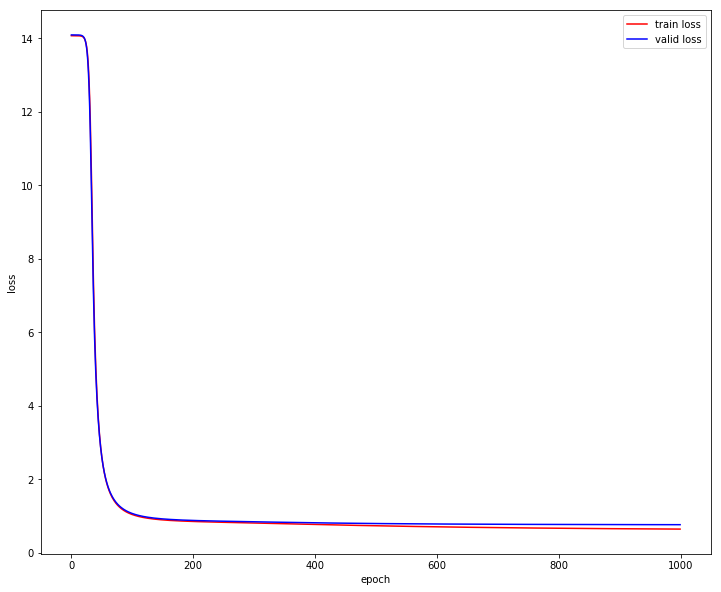

In [10]:
plt.figure(figsize=(12,10))
plt.plot(train_loss_history, color="red", label="train loss")
plt.plot(valid_loss_history, color="blue", label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

### results on validation set

In [11]:
results = validset[["gender", "age_desc","occ_desc", "title", "genre", "rating"]].copy()
results["prediction (rnd.)"] = np.asarray(np.round(final_valid_predictions), dtype=np.int16)
results["prediction (prc.)"] = final_valid_predictions
results

,gender,age_desc,occ_desc,title,genre,rating,prediction (rnd.),prediction (prc.)
91691,M,18-24,college/grad student,Four Weddings and a Funeral (1994),Comedy|Romance,2,3,2.739316
413978,M,25-34,programmer,King of New York (1990),Action|Crime,5,3,3.136971
524822,M,18-24,college/grad student,Operation Condor (Feiying gaiwak) (1990),Action|Adventure|Comedy,3,3,3.027974
828503,M,35-44,artist,Popeye (1980),Adventure|Comedy|Musical,3,2,2.367431
144346,M,25-34,customer service,"Last of the Mohicans, The (1992)",Action|Romance|War,3,3,3.052390
154235,M,25-34,technician/engineer,"Rock, The (1996)",Action|Adventure|Thriller,4,4,3.608633
645684,M,18-24,college/grad student,Peter Pan (1953),Animation|Children's|Fantasy|Musical,4,3,3.228327
588094,F,45-49,other or not specified,"Mosquito Coast, The (1986)",Drama,1,2,1.565945
205295,M,Under 18,K-12 student,Run Lola Run (Lola rennt) (1998),Action|Crime|Romance,5,4,3.875141
130182,M,25-34,executive/managerial,Snow Day (2000),Comedy,3,3,2.667322
